Initial bed configuration: {'A': 48, 'B': 33, 'C': 23, 'D': 14, 'E': 13, 'F': 34}
Total beds: 165

Starting optimization process...
Stopping early at iteration 597 due to no improvement.


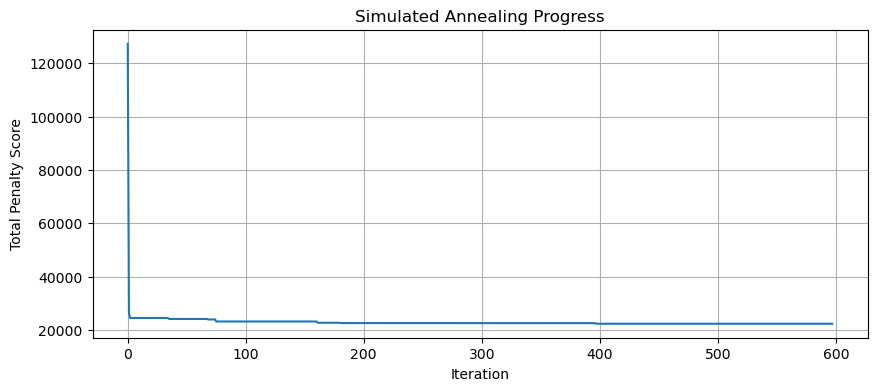


--- Best Bed Allocation Found by Optimizer ---
  Ward A: 48 beds
  Ward B: 34 beds
  Ward C: 18 beds
  Ward D: 15 beds
  Ward E: 14 beds
  Ward F: 36 beds

Minimum Total Penalty Found: 22374.00
Time Taken for optimization: 42.16 seconds

--- Verifying performance of best configuration ---
  Verification Run - Final Penalty Score: 58072.00
  Verification Run - Ward F Admission Rate: 97.09%


In [1]:
import numpy as np
import random
import heapq
import matplotlib.pyplot as plt
import time

# ==============================================================================
# PART 1: The Core Simulation Model
# ==============================================================================
# This class represents the hospital and contains all the rules for patient flow.
# It is the "engine" that the optimizer will use to test different scenarios.

class HospitalModel:
    """Represents the hospital's rules, state, and statistics for a single simulation run."""
    def __init__(self, bed_config):
        # --- Static Parameters (The "Rules") ---
        self.wards = list(bed_config.keys())
        self.capacities = bed_config.copy()
        self.arrival_rates = {'A': 14.5, 'B': 11.0, 'C': 8.0, 'D': 6.5, 'E': 5.0, 'F': 13.0}
        self.mean_stays = {'A': 2.9, 'B': 4.0, 'C': 4.5, 'D': 1.4, 'E': 3.9, 'F': 2.2}
        self.urgency_points = {'A': 7, 'B': 5, 'C': 2, 'D': 10, 'E': 5, 'F': 0}
        self.reloc_probs = {
            'A': {'B': 0.05, 'C': 0.10, 'D': 0.05, 'E': 0.80},
            'B': {'A': 0.20, 'C': 0.50, 'D': 0.15, 'E': 0.15},
            'C': {'A': 0.30, 'B': 0.20, 'D': 0.20, 'E': 0.30},
            'D': {'A': 0.35, 'B': 0.30, 'C': 0.05, 'E': 0.30},
            'E': {'A': 0.20, 'B': 0.10, 'C': 0.60, 'D': 0.10},
            'F': {'A': 0.20, 'B': 0.20, 'C': 0.20, 'D': 0.20, 'E': 0.20}
        }
        
        # --- Dynamic State Variables (What changes during simulation) ---
        self.occupied_beds = {w: 0 for w in self.wards}
        self.stats = {
            'total_arrivals': {w: 0 for w in self.wards},
            'primary_admissions': {w: 0 for w in self.wards},
            'relocated_from': {w: 0 for w in self.wards},
            'lost_patients': {w: 0 for w in self.wards}
        }

    def handle_arrival(self, patient_type):
        """Handles a patient arrival and returns the ward they were admitted to (or None)."""
        self.stats['total_arrivals'][patient_type] += 1
        
        # --- Primary Admission Attempt ---
        if self.occupied_beds[patient_type] < self.capacities[patient_type]:
            self.occupied_beds[patient_type] += 1
            self.stats['primary_admissions'][patient_type] += 1
            return patient_type
        
        # --- Relocation Attempt ---
        else:
            self.stats['relocated_from'][patient_type] += 1
            
            # Choose an alternative ward based on probabilities
            reloc_options = self.reloc_probs.get(patient_type, {})
            if not reloc_options: # Handle case where a type has no relocation options
                self.stats['lost_patients'][patient_type] += 1
                return None
                
            wards = list(reloc_options.keys())
            probs = list(reloc_options.values())
            alt_ward = np.random.choice(wards, p=probs)
            
            if self.occupied_beds[alt_ward] < self.capacities[alt_ward]:
                self.occupied_beds[alt_ward] += 1
                return alt_ward
            else:
                self.stats['lost_patients'][patient_type] += 1
                return None

    def handle_departure(self, ward_of_admission):
        """Frees up a bed in the specified ward."""
        if self.occupied_beds[ward_of_admission] > 0:
            self.occupied_beds[ward_of_admission] -= 1

def simulate_hospital_flow(bed_config, duration=365, burn_in=50):
    """
    This is the main simulation function. It takes a bed layout and returns
    the key performance metrics needed by the optimizer.
    """
    model = HospitalModel(bed_config)
    event_list = []
    current_time = 0.0

    def schedule_event(delay, event_type, details):
        heapq.heappush(event_list, (current_time + delay, event_type, details))

    # Kickstart by scheduling the first arrival for each patient type
    for p_type in model.wards:
        if p_type in model.arrival_rates:
            delay = np.random.exponential(1.0 / model.arrival_rates[p_type])
            schedule_event(delay, 'ARRIVAL', {'patient_type': p_type})

    # Main simulation loop
    while event_list and current_time < duration:
        time, event_type, details = heapq.heappop(event_list)
        current_time = time

        if event_type == 'ARRIVAL':
            p_type = details['patient_type']
            # Always schedule the next arrival for this type
            delay = np.random.exponential(1.0 / model.arrival_rates[p_type])
            schedule_event(delay, 'ARRIVAL', {'patient_type': p_type})
            
            # Only process/collect stats after the burn-in period
            if current_time > burn_in:
                ward_admitted = model.handle_arrival(p_type)
                if ward_admitted:
                    stay = np.random.exponential(model.mean_stays[p_type])
                    schedule_event(stay, 'DEPARTURE', {'ward': ward_admitted})
        
        elif event_type == 'DEPARTURE':
            if current_time > burn_in:
                model.handle_departure(details['ward'])

    # --- Calculate final metrics at the end of the simulation ---
    # 1. Total penalty score from relocated patients
    total_penalty = sum(model.urgency_points[w] * model.stats['relocated_from'][w] for w in model.wards if w != 'F')
    
    # 2. Admission rate for Ward F
    f_arrivals = model.stats['total_arrivals']['F']
    f_admissions = model.stats['primary_admissions']['F']
    f_admission_rate = (f_admissions / f_arrivals) if f_arrivals > 0 else 1.0

    return f_admission_rate, total_penalty


# ==============================================================================
# PART 2: The Simulated Annealing Optimizer
# ==============================================================================
# This section uses the simulation model to find the best bed layout.

def objective_function(bed_config):
    """
    This is the function the optimizer tries to minimize.
    It returns a single "cost" value for a given bed layout.
    """
    f_admission_rate, penalty_score = simulate_hospital_flow(bed_config=bed_config)
    
    # Add a massive penalty if the Ward F admission constraint is violated.
    # This forces the optimizer to find solutions that are valid.
    if f_admission_rate < 0.95:
        penalty_score += 100000 

    return penalty_score

def generate_neighbor(config, src_weights):
    """
    Creates a new "neighbor" configuration by intelligently moving one bed.
    """
    config = config.copy()
    
    # Choose a source ward to take a bed FROM.
    # It must have beds to give and we prefer to take from low-urgency wards.
    valid_sources = {w: weight for w, weight in src_weights.items() if config[w] > 0}
    if not valid_sources: return config
    
    items = list(valid_sources.items())
    wards, weights = zip(*items)
    total_weight = sum(weights)
    probs = [w / total_weight for w in weights]
    src = np.random.choice(wards, p=probs)

    # Choose a destination ward to give the bed TO.
    dst_candidates = [w for w in config.keys() if w != src]
    dst = random.choice(dst_candidates)

    config[src] -= 1
    config[dst] += 1
    return config

def simulated_annealing_optimizer(initial_config, src_weights, max_iter=2000):
    """
    The main simulated annealing algorithm.
    """
    current_config = initial_config.copy()
    current_cost = objective_function(current_config)
    
    best_config = current_config.copy()
    best_cost = current_cost
    
    cost_history = [current_cost]
    patience = 200
    stall_counter = 0

    T0 = 20.0  # Initial temperature
    T_end = 0.1 # Final temperature

    for k in range(1, max_iter + 1):
        T = T0 * (T_end / T0) ** (k / max_iter)
        
        neighbor_config = generate_neighbor(current_config, src_weights)
        cost = objective_function(neighbor_config)
        
        delta = cost - current_cost
        
        # Metropolis acceptance criterion
        if delta < 0 or random.random() < np.exp(-delta / T):
            current_config = neighbor_config
            current_cost = cost
        
        # Track the best valid solution found so far
        if current_cost < best_cost:
            best_config = current_config.copy()
            best_cost = current_cost
            stall_counter = 0
        else:
            stall_counter += 1
        
        cost_history.append(current_cost)
        
        if stall_counter >= patience:
            print(f"Stopping early at iteration {k} due to no improvement.")
            break
            
    # Plot the optimization progress
    plt.figure(figsize=(10,4))
    plt.plot(cost_history)
    plt.title("Simulated Annealing Progress")
    plt.xlabel("Iteration")
    plt.ylabel("Total Penalty Score")
    plt.grid(True)
    plt.show()

    return best_config, best_cost

# ==============================================================================
# PART 3: Main Execution Block
# ==============================================================================

# --- Define Global Parameters for the run ---
WARDS = ['A', 'B', 'C', 'D', 'E', 'F']
urgency_points = {'A': 7, 'B': 5, 'C': 2, 'D': 10, 'E': 5, 'F': 0}
src_weights = {w: 1 / urgency_points[w] if urgency_points.get(w, 0) > 0 else 0 for w in WARDS if w != 'F'}

# --- Set Initial Configuration ---
# Start with a simple, balanced configuration.
initial_beds = {'A': 48, 'B': 33, 'C': 23, 'D': 14, 'E': 13, 'F': 34} 
print(f"Initial bed configuration: {initial_beds}")
print(f"Total beds: {sum(initial_beds.values())}")

# --- Run the Optimizer ---
print("\nStarting optimization process...")
start_time = time.time()
best_config, best_cost = simulated_annealing_optimizer(initial_beds, src_weights)
end_time = time.time()

# --- Report Final Results ---
print("\n--- Best Bed Allocation Found by Optimizer ---")
for ward in WARDS:
    print(f"  Ward {ward}: {best_config[ward]} beds")

print(f"\nMinimum Total Penalty Found: {best_cost:.2f}")
print(f"Time Taken for optimization: {end_time - start_time:.2f} seconds")

# --- Final verification run with the best configuration ---
print("\n--- Verifying performance of best configuration ---")
final_f_rate, final_penalty = simulate_hospital_flow(best_config, duration=365*2, burn_in=50)
print(f"  Verification Run - Final Penalty Score: {final_penalty:.2f}")
print(f"  Verification Run - Ward F Admission Rate: {final_f_rate:.2%}")

